# Knowledge Graph from PDF file

## Import function

In [1]:
import sys
import re
import json
import numpy as np


import matplotlib.pyplot as plt
import pandas as pd
import pdfplumber
import networkx as nx
import textacy

import spacy
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

import seaborn as sns

import itertools
from sklearn.decomposition import PCA
from node2vec import Node2Vec as n2v
from tabula.io import read_pdf
from spacy import displacy

from openie import StanfordOpenIE
from pyvis.network import Network
import os

sns.set()
%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jawakumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Module 1 - Processing the PDF

### Reading the raw texts from PDF file

In [2]:
# https://pypi.org/project/pdfplumber/0.1.2/

pdf_text=[]

with pdfplumber.open(r'data/CAP393 Regulations made under powers in the Civil Aviation Act 1982 and the Air Navigation Order 2016.pdf') as pdf:
    for pgnum in range(len(pdf.pages)):
        first_page = pdf.pages[pgnum]
        pdf_text.append(first_page.extract_text())

### Exploring the output from pdfplumber

In [3]:
print(pdf_text[7])

Section 2: 
CAP 393 The Rules of the Air Regulations 2015 
SCHEDULE 1  Regulation 2 
Contents 
Section 1 
Interpretation 
1. Interpretation
Section 2 
Application and compliance 
2. Application of Rules to aircraft
3. Permissions
Section 3 
General rules, collision avoidance and protection of persons and property 
4. Aerobatic flights
5. Landing and taking off within congested areas and near open-air assemblies
6. Test flying over congested areas
7. Launching, picking up and dropping of tow ropes, etc.
8. Avoiding aerial collisions
9. Order of landing
10. Landing and take-off
11. Flight within aerodrome traffic zones
12. Movement of aircraft on uncontrolled aerodromes
13. Access to and movement of persons and vehicles on the aerodrome
Section 4 
Lights to be displayed by aircraft 
14. Stationary helicopters on offshore or renewable energy installations
15. Failure of anti-collision and navigation lights
16. Airships by day
April 2015   Page 2 


In [4]:
# Checking the performace of the package bby comparing with the actual text from specifc pages that is copied manualy

In [5]:
with open('data/text_from_page16.txt', 'r') as file:
    text_from_page_16 = file.read()

print(text_from_page_16)

Section 2: CAP 393 The Rules of the Air Regulations 2015
(3) For the purposes of this rule an airship is not under command when it is unable to execute a manoeuvre which it may be required to execute by these Rules.
Section 5
Aerodrome visual signals and markings
Aerodrome Visual Signals and Markings
17. Within the United Kingdom any signal or marking which is specified in these Rules
and which is given or displayed—
(a) by any person in an aircraft;
(b) at an aerodrome; or
(c) at any other place which is being used by aircraft for landing or take-off,
has the meaning assigned to it by this section.
Misuse of signals and markings
18. A person in an aircraft or on an aerodrome or at any place at which an aircraft is
taking off or landing must not—
(a) make any signal which may be confused with a signal specified in SERA.3301 and Appendix 1 to SERA; or
(b) except with lawful authority, make any signal which the person knows or ought reasonably to know to be a signal in use for signalling

In [6]:
with open('data/text_from_page21.txt', 'r') as file:
    text_from_page_21 = file.read()

print(text_from_page_21)

CAP 393
Section 2: The Rules of the Air Regulations 2015
(a) April 2015
The instrument flight rules are prescribed by Section 5 of SERA.
(a) in Class C airspace above flight level 195; or
(b) along a Class C ATS route at any level,
must be flown in accordance with the instrument flight rules(a).
(2) Paragraph (1) does not apply to an aircraft which is flying in accordance with a permission issued by the CAA.
(3) In this Rule “Class C ATS route” means a route notified as such.
Use of radio navigation aids
24.—(1) Subject to paragraph (2), the commander of an aircraft must not make use of a radio navigation aid without complying with such restrictions and procedures as may be notified in relation to that aid.
(2) The commander of an aircraft is not required to comply with this rule if—
(a) the aircraft is required to comply with an air traffic control clearance issued for the flight; or
(b) the commander is otherwise authorised by an air traffic control unit.
Air traffic control clearanc

In [7]:
with open('data/text_from_page44.txt', 'r') as file:
    text_from_page_44 = file.read()

print(text_from_page_44)

CAP 393
Section 3: The Air Navigation (General) Regulations 2006
that may be required for landing because of the forecast wind conditions at the aerodrome of intended destination or any alternate aerodrome.
(20) If an alternate aerodrome is designated in the flight plan, the specified landing distance required may be that appropriate to that alternate aerodrome when assessing the ability of the aeroplane to satisfy sub-paragraph (19) at the aerodrome of intended destination.
(21) For the purposes of sub-paragraphs (19) and (20) the specified landing distance required shall be that specified as being appropriate to:
(a) the landing weight;
(b) the altitude of the aerodrome;
(c) the temperature in the specified international standard atmosphere appropriate to the altitude at the aerodrome;
(d) a level surface in the case of runways usable in both direction; or the average slope of the runway in the case of runways usable in only one direction; and
(e) still air conditions in the case of 

In [8]:
with open('data/text_from_page94.txt', 'r') as file:
    text_from_page_94 = file.read()

print(text_from_page_94)

Part II: CAP 393 Functions Conferred on the Authority by or under Air Navigation Orders
PART II
Functions Conferred on the Authority by or under Air Navigation Orders
6 Regulation of the conduct of the Authority
(1)
The functions conferred on the Authority by or under Air Navigation Orders with respect to:
(a) registration of aircraft;
(b) certification of operators of aircraft;
(c) certification of airworthiness of aircraft;
(d) noise certification;
(e) certification of compliance with the requirements for the emission by aircraft engines of unburned hydrocarbons;
(f) personnel licensing;
(g) licensing of aerodromes;
(h) validation of any certificate or licence;
(i) approval of equipment and approval or authorisation of persons;
(j) approval of schemes for the regulation of the flight times of aircraft crew;
(k) receiving reports of reportable occurrences;
(l) making air traffic directions;
(m) making airspace policy directions;
are hereby prescribed for the purposes of section 7(2) o

In [9]:
# Comparing with the text extracted from pdfplumber

In [10]:
def compare_pages(actual,extract):
    out = {}
    out['New lines in original Doc'] = len(re.findall('\n',actual))
    out['New lines in extracted Doc'] = len(re.findall('\n',extract))
    out['No of words in actual Doc'] = len(actual.split())
    out['No of words in extracted Doc'] = len(extract.split())
    out['No of words missed'] = len(set(actual.split()) - set(extract.split()))
    return out

In [11]:
compare_pages(text_from_page_16,pdf_text[15])

{'New lines in original Doc': 19,
 'New lines in extracted Doc': 24,
 'No of words in actual Doc': 231,
 'No of words in extracted Doc': 231,
 'No of words missed': 0}

In [12]:
compare_pages(text_from_page_21,pdf_text[20])

{'New lines in original Doc': 22,
 'New lines in extracted Doc': 33,
 'No of words in actual Doc': 355,
 'No of words in extracted Doc': 355,
 'No of words missed': 0}

In [13]:
compare_pages(text_from_page_44,pdf_text[43])

{'New lines in original Doc': 18,
 'New lines in extracted Doc': 38,
 'No of words in actual Doc': 386,
 'No of words in extracted Doc': 386,
 'No of words missed': 0}

In [14]:
compare_pages(text_from_page_94,pdf_text[93])

{'New lines in original Doc': 23,
 'New lines in extracted Doc': 30,
 'No of words in actual Doc': 252,
 'No of words in extracted Doc': 252,
 'No of words missed': 0}

### Finding the Contents page and extracting the titles and headings

In [15]:
# Cleaning of the text to filter for stop lists

In [16]:
def pdf_clean(txt):
    l=[]
    for i in txt.split('\n'):
        l.append(i)
        if i.find('CAP 393')==0:
            l=[]
            l.append(i)
    return '\n'.join(l[:-1])

In [17]:
pdf_cleanpages=[]

for pdf_cleanpage in pdf_text:
    pdf_cleanpages.append(pdf_clean(pdf_cleanpage))

In [18]:
# https://spacy.io/models/en
nlp = spacy.load('en_core_web_sm')

In [19]:
## Contents page extraction from pdfplumber results

contensts_text = nlp(pdf_cleanpages[7]+pdf_cleanpages[8]).text

contensts_text = contensts_text[contensts_text.find('Contents')+8:]
print(contensts_text)

 
Section 1 
Interpretation 
1. Interpretation
Section 2 
Application and compliance 
2. Application of Rules to aircraft
3. Permissions
Section 3 
General rules, collision avoidance and protection of persons and property 
4. Aerobatic flights
5. Landing and taking off within congested areas and near open-air assemblies
6. Test flying over congested areas
7. Launching, picking up and dropping of tow ropes, etc.
8. Avoiding aerial collisions
9. Order of landing
10. Landing and take-off
11. Flight within aerodrome traffic zones
12. Movement of aircraft on uncontrolled aerodromes
13. Access to and movement of persons and vehicles on the aerodrome
Section 4 
Lights to be displayed by aircraft 
14. Stationary helicopters on offshore or renewable energy installations
15. Failure of anti-collision and navigation lights
16. Airships by dayCAP 393 The Rules of the Air Regulations 2015 
Section 5 
Aerodrome visual signals and markings 
17. Aerodrome Visual Signals and Markings
18. Misuse of sign

In [20]:
## Mapping the section, headings and titles to a dataframe

sections = [i for i in contensts_text.split('\n') if i.find('Section')==0]
sections_pd={}
for n in range(len(sections)):
    if n==len(sections)-1:
        titles = contensts_text[contensts_text.find(sections[n])+10:]
    else:
        titles = contensts_text[contensts_text.find(sections[n])+10:contensts_text.find(sections[n+1])]
    titles = titles.split('\n')
    titles = [re.sub('CAP 393 The Rules of the Air Regulations 2015 ','',i) for i in titles]
    titles = [i for i in titles if len(i)>0]
    heading = []
    title_final = []
    for i in range(len(titles)):
        if len(re.findall(r'[0-9]',titles[i]))==0:
            heading.append(titles[i])
        else:
            title_final.append(titles[i])
    sections_pd[sections[n]] = {''.join(heading):title_final}

In [21]:
sections_pd

{'Section 1 ': {'Interpretation ': ['1. Interpretation']},
 'Section 2 ': {'Application and compliance ': ['2. Application of Rules to aircraft',
   '3. Permissions']},
 'Section 3 ': {'General rules, collision avoidance and protection of persons and property ': ['4. Aerobatic flights',
   '5. Landing and taking off within congested areas and near open-air assemblies',
   '6. Test flying over congested areas',
   '7. Launching, picking up and dropping of tow ropes, etc.',
   '8. Avoiding aerial collisions',
   '9. Order of landing',
   '10. Landing and take-off',
   '11. Flight within aerodrome traffic zones',
   '12. Movement of aircraft on uncontrolled aerodromes',
   '13. Access to and movement of persons and vehicles on the aerodrome']},
 'Section 4 ': {'Lights to be displayed by aircraft ': ['14. Stationary helicopters on offshore or renewable energy installations',
   '15. Failure of anti-collision and navigation lights',
   '16. Airships by day']},
 'Section 5 ': {'Aerodrome vis

In [22]:
df_sect_list=[]
for section_item in pd.DataFrame(sections_pd.items()).values:
    df_sect = pd.Series(section_item[1], name='Title').rename_axis('Heading').explode().reset_index()
    df_sect['Section'] = section_item[0]
    df_sect_list.append(df_sect)

In [23]:
## Final dataframe creation of the Contents page

contents_section_df = pd.concat(df_sect_list,axis=0)

contents_section_df = contents_section_df[['Section','Heading','Title']]
contents_section_df

,Section,Heading,Title
0,Section 1,Interpretation,1. Interpretation
0,Section 2,Application and compliance,2. Application of Rules to aircraft
1,Section 2,Application and compliance,3. Permissions
0,Section 3,"General rules, collision avoidance and protect...",4. Aerobatic flights
1,Section 3,"General rules, collision avoidance and protect...",5. Landing and taking off within congested are...
2,Section 3,"General rules, collision avoidance and protect...",6. Test flying over congested areas
3,Section 3,"General rules, collision avoidance and protect...","7. Launching, picking up and dropping of tow r..."
4,Section 3,"General rules, collision avoidance and protect...",8. Avoiding aerial collisions
5,Section 3,"General rules, collision avoidance and protect...",9. Order of landing
6,Section 3,"General rules, collision avoidance and protect...",10. Landing and take-off


### Mapping the texts to their contents - Reconstructing the texts

In [24]:
# Texts after Contents page
textsin_pdf = ''.join(pdf_cleanpages[9:]).split('\n')
textsin_pdf

['CAP 393 The Rules of the Air Regulations 2015 ',
 'Section 1 ',
 'Interpretation ',
 'Interpretation ',
 '1.—(1) In these Rules “anti-collision light” means— ',
 '(a) in relation to rotorcraft, a flashing red light; and',
 '(b) in relation to any other aircraft, a flashing red or flashing white light,',
 'in either case showing in all directions. ',
 '(2) Subject to paragraph (3), terms used in these Rules which are defined in article 2 of',
 'the Standardised European Rules of the Air Regulation(a) have the same meaning as',
 'given in that article.',
 '(3) The term “aerodrome traffic zone” has the same meaning as given in article 5 of the',
 'Air Navigation Order 2016(b).',
 '(4) References in these Rules to “SERA” followed by a number refer to the provision with',
 'the corresponding number in SERA(c).',
 'Section 2 ',
 'Application and compliance ',
 'Application of Rules to aircraft ',
 '2. Subject to rule 6 and to articles 249(3) and 22(1) of the Air Navigation Order 2016 and',

In [25]:
## Mapping of the titles to their contents based and storing the index for each passage

section_title_map_text = []


for n in range(len(sections)):
    if n==len(sections)-1:
        
        for r in range(len(textsin_pdf)):
            if textsin_pdf[r].find(sections[n])==0:
                start = r+1
                break
        text_to_process = textsin_pdf[start:]
    else:
        for r in range(len(textsin_pdf)):
            if textsin_pdf[r].find(sections[n])==0:
                start = r+1
                break

        for r in range(len(textsin_pdf)):
            if textsin_pdf[r].find(sections[n+1])==0:
                end = r
                break
        text_to_process = textsin_pdf[start:end]        
    
    
    sections_titles_df = contents_section_df[contents_section_df['Section']==sections[n]]
    
    sections_titles = [i[i.find('. ')+2:]+' ' for i in sections_titles_df['Title'].values]
    
    for t in range(len(sections_titles)):
        
        if t==len(sections_titles)-1:
            
            section_title_map_text.append((sections_titles_df['Title'].values[t],
                                          text_to_process[text_to_process.index(sections_titles[t])+1:]))
            
            
        else:
            
            section_title_map_text.append((sections_titles_df['Title'].values[t],
                                          text_to_process[text_to_process.index(sections_titles[t])+1:
                                                         text_to_process.index(sections_titles[t+1])]))
            
last_title = last_sent = section_title_map_text[-1][0]
last_sent = section_title_map_text[-1][1][:section_title_map_text[-1][1].index('Schedule 2 ')]
section_title_map_text.pop(-1)
section_title_map_text.append((last_title,last_sent))

In [26]:
section_title_map_text

[('1. Interpretation',
  ['Interpretation ',
   '1.—(1) In these Rules “anti-collision light” means— ',
   '(a) in relation to rotorcraft, a flashing red light; and',
   '(b) in relation to any other aircraft, a flashing red or flashing white light,',
   'in either case showing in all directions. ',
   '(2) Subject to paragraph (3), terms used in these Rules which are defined in article 2 of',
   'the Standardised European Rules of the Air Regulation(a) have the same meaning as',
   'given in that article.',
   '(3) The term “aerodrome traffic zone” has the same meaning as given in article 5 of the',
   'Air Navigation Order 2016(b).',
   '(4) References in these Rules to “SERA” followed by a number refer to the provision with',
   'the corresponding number in SERA(c).']),
 ('2. Application of Rules to aircraft',
  ['2. Subject to rule 6 and to articles 249(3) and 22(1) of the Air Navigation Order 2016 and',
   'insofar as these Rules apply to aircraft they apply— ',
   '(a) to all air

## Creation of the graphs - Module 2

### Custom rules based triplets creation

In [27]:
# https://spacy.io/usage/visualizers

sen = nlp("""Aerobatic flight is not permitted over the congested area of any city town or settlement""")
displacy.render(sen, style='dep', jupyter=True, options={'distance': 60})

In [28]:
def pairwise(iterable):
    a = iter(iterable)
    return zip(a, a)

In [29]:
whole_sent = section_title_map_text[0][1]

In [30]:
# Custom rules triplet extraction function

def custom_rules_triplets(whole_sent):
    pairs= []
    for sent in whole_sent:
        pair = []

        sent = re.sub("[^a-zA-Z ,\.-]", "", sent)
        sent = nlp(sent)
        for i in sent:
            if i.tag_ not in ['DT','VBZ','RB'] and (i.text not in ['Subject','paragraph','\n']):
                if i.tag_[:2] in ['NN','CD','NU']:
                    pair.append(['1',i,i.tag_])
                elif len(i)>1:
                    pair.append(['2',i,i.tag_])
        pairs.append(pair)

    node=[]
    graph_con=[]
    tag = '1'
    for graph_pair in pairs:
        for n in graph_pair:
            if n[0]==tag:
                node.append(n[1].text)
            if n[0]!=tag:
                graph_con.append(tag+'_'+' '.join(node))
                node = [n[1].text]
                tag = n[0]

    graph_nodes = [(x,y) for x,y in pairwise(graph_con)]
    graph_final_con = [] 
    for i in range(len(graph_nodes)-1):
        graph_final_con.append([graph_nodes[i][0],graph_nodes[i][1],graph_nodes[i+1][0]])


    graph_df = pd.DataFrame([[j.split('_')[1] for j in i] for i in graph_final_con],columns=['src','relation','to'])
    
    return graph_df

In [31]:
titles_custom = []

for title,text in section_title_map_text:
    graph_df = custom_rules_triplets(text)
    
    graph_df['Titles'] = title
    
    titles_custom.append(graph_df)

In [32]:
titles_custom_df  = pd.concat(titles_custom)

In [33]:
# https://www.nltk.org/_modules/nltk/stem/wordnet.html

lmtzr = WordNetLemmatizer()

In [34]:
# Lemmatizing the source and target nodes

df_graphs_custom = pd.DataFrame([(lmtzr.lemmatize(i[0].lower()),
                           i[1].lower(),
                           lmtzr.lemmatize(i[2].lower()),i[3]) for i in titles_custom_df.values],
            columns=['subject','relation','object','Titles'])


In [35]:
# Triplets for custom rule based SVO
df_graphs_custom

,subject,relation,object,Titles
0,interpretation,in,rule,1. Interpretation
1,rule,anti collision,light,1. Interpretation
2,light,in,relation,1. Interpretation
3,relation,to rotorcraft flashing red,light,1. Interpretation
4,light,and in,relation,1. Interpretation
...,...,...,...,...
661,km,and comply with,condition,25. Air traffic control clearance for flights ...
662,condition,or,requirement,25. Air traffic control clearance for flights ...
663,requirement,specified by appropriate,air traffic control unit instrument flight rules,25. Air traffic control clearance for flights ...
664,air traffic control unit instrument flight rules,are prescribed by,section,25. Air traffic control clearance for flights ...


### Stanford OpenIE based triplets creation

In [36]:
# https://github.com/philipperemy/stanford-openie-python

properties = {
    'openie.affinity_probability_cap': 2 / 3,
}
triples = []
titles_fin =[]
with StanfordOpenIE(properties=properties) as client:
    
    
    for title,text in section_title_map_text:
        text = ''.join(text)
#         text[text.find(re.findall(r'[0-9]\.',text)[0]):]
        text = re.sub("[^a-zA-Z ,\.-]", "", text)
        text = ' '.join([i for i in text.split() if len(i)>2])
        
        for triple in client.annotate(text):
            triples.append(triple)
            titles_fin.append(title)

Starting server with command: java -Xmx8G -cp /Users/jawakumar/.stanfordnlp_resources/stanford-corenlp-4.1.0/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-62658a8bb70b4f33.props -preload openie


In [37]:
# Lemmatizing the source and target nodes

df_graphs_openIE = pd.DataFrame([(lmtzr.lemmatize(i['subject'].lower()),
                           i['relation'].lower(),
                           lmtzr.lemmatize(i['object'].lower())) for i in triples],
            columns=['subject','relation','object'])

df_graphs_openIE['Titles'] = titles_fin

In [38]:
# Triplets for Stanford OpenIE based SVO
df_graphs_openIE

,subject,relation,object,Titles
0,rules anti-collision light,means,relation rotorcraft flashing,1. Interpretation
1,interpretation,means,relation rotorcraft,1. Interpretation
2,rules anti-collision light,means,relation rotorcraft,1. Interpretation
3,interpretation,means,relation rotorcraft flashing,1. Interpretation
4,air regulationa,have,meaning asgiven,1. Interpretation
...,...,...,...,...
304,unit.a instrument flight rules,are prescribed,section sera.cap,25. Air traffic control clearance for flights ...
305,paragraphc,remain within,airspace,25. Air traffic control clearance for flights ...
306,paragraphc,least metres away,horizontally cloudand flight visibility,25. Air traffic control clearance for flights ...
307,paragraphc,notified for,purpose,25. Air traffic control clearance for flights ...


In [ ]:
## Graphs for title no 1 contents in custom rule based approach

In [303]:
G = nx.from_pandas_edgelist(df_graphs_custom[df_graphs_custom['Titles'] == '1. Interpretation'],
                            edge_attr='relation',source='subject',target='object')

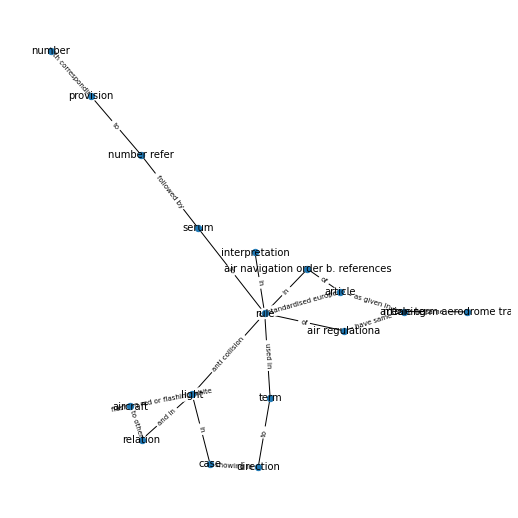

In [331]:
plt.figure(figsize=(7, 7))
pos = nx.spring_layout(G)  # For better example looking
nx.draw(G, pos, with_labels=True,node_size=40,font_size=10)
labels = {e: G.edges[e]['relation'] for e in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels,font_size=7)
plt.show()

In [ ]:
## Graphs for title no 1 contents in Stanford OpenIE based approach

In [332]:
G = nx.from_pandas_edgelist(df_graphs_openIE[df_graphs_openIE['Titles'] == '1. Interpretation'],
                            edge_attr='relation',source='subject',target='object')

In [267]:
# df_graphs_openIE[df_graphs_openIE['Titles'] == '1. Interpretation']

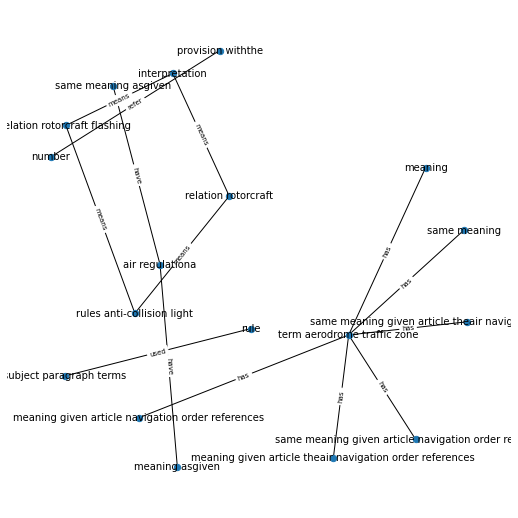

In [333]:
plt.figure(figsize=(7, 7))
pos = nx.spring_layout(
    G,
    k=1,
    pos=None,
    fixed=None,
    iterations=50,
    threshold=0.0001,
    weight='weight',
    scale=10,
    center=None,
    dim=2,
    seed=None,
)  # For better example looking
nx.draw(G, pos, with_labels=True,node_size=40,font_size=10)
labels = {e: G.edges[e]['relation'] for e in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels,font_size=7)
plt.show()

### Adding of Titles indices in all the edges on the triplets

In [39]:
df_graphs_custom['edge'] = [i+' {_titleindx_'+j[:j.find('. ')]+'}' for i,j in df_graphs_custom[['relation','Titles']].values]

df_graphs_openIE['edge'] = [i+' {_titleindx_'+j[:j.find('. ')]+'}' for i,j in df_graphs_openIE[['relation','Titles']].values]

### Table extraction and triplet formation of tables

In [40]:
# https://tabula-py.readthedocs.io/en/latest/getting_started.html#example

dfs = read_pdf("data/CAP393 Regulations made under powers in the Civil Aviation Act 1982 and the Air Navigation Order 2016.pdf", pages='all', lattice=True)

In [41]:
# Function to handle multple columns and rows from a table extracted

def table_conv(dfs):
    try:
        mulcol = [[i for i in dfs[dfs[dfs.columns[0]].apply(str) == 'nan'].columns if i.find('Unnamed:')<0]]
        mulcol.extend([[i for i in colname if str(i).find('Unnamed:')<0 and str(i)!='nan'] for colname 
                       in dfs[dfs[dfs.columns[0]].apply(str) == 'nan'].values])

        header = pd.MultiIndex.from_product(mulcol
                                        )
        return pd.DataFrame(dfs[dfs[dfs.columns[0]].apply(str) != 'nan'][dfs.columns[1:]].values, 
                      index = dfs[dfs[dfs.columns[0]].apply(str) != 'nan'][dfs.columns[0]].values,
                      columns=header)
    except :
        mulcol = [i for i in dfs.columns if i.find('Unnamed:')<0]
        header = pd.MultiIndex.from_product(mulcol
                                        )
        return pd.DataFrame(dfs[dfs[dfs.columns[0]].apply(str) != 'nan'].values, 
#                       index = dfs[dfs[dfs.columns[0]].apply(str) != 'nan'][dfs.columns[0]].values,
                      columns=header)

In [42]:
table_extracted =[]

for tables in dfs:
    try:
        table_extracted.append(table_conv(tables))
    except:
        pass

In [43]:
table_extracted[0]

ircraft with 20 or more passengers  \
                                                   Passenger Seats Available\r20 or more30 or more\rColumn 1Column 2Column 3   
                                                                                                                        Male   
Passengers on all flights except holiday charters                                                88kg                          
Passengers on holiday charters                                                                   83gk                          
Children (between 2–12 years) or infants under ...                                               35kg                          
Infants under 2 years of age if sharing a seat ...                                                0kg                          
Flight crew                                                                                      85kg                          
Cabin crew                                                                                       75kg                          

                                                                     
                                                                     
                                                   Female All adult  
Passengers on all flights except holiday charters    70kg      84kg  
Passengers on holiday charters                       69kg      76kg  
Children (between 2–12 years) or infants under ...   35kg       NaN  
Infants under 2 years of age if sharing a seat ...    0kg       NaN  
Flight crew                                          85kg       NaN  
Cabin crew                                           75kg       NaN

In [44]:
# Function to extract triplets in the tables

def table_triplets_extract(table):
    return [(ind,
             col[-1],
             table.loc[ind][col]) for col,ind in itertools.product(list(table.columns), 
                                                                   list(table.index)) if str(table.loc[ind][col])!='nan']

In [45]:
table_triplets_extract(table_extracted[0])

[('Passengers on all flights except holiday charters', 'Male', '88kg'),
 ('Passengers on holiday charters', 'Male', '83gk'),
 ('Children (between 2–12 years) or infants under 2\ryears of age if occupying a separate seat',
  'Male',
  '35kg'),
 ('Infants under 2 years of age if sharing a seat with\ran adult',
  'Male',
  '0kg'),
 ('Flight crew', 'Male', '85kg'),
 ('Cabin crew', 'Male', '75kg'),
 ('Passengers on all flights except holiday charters', 'Female', '70kg'),
 ('Passengers on holiday charters', 'Female', '69kg'),
 ('Children (between 2–12 years) or infants under 2\ryears of age if occupying a separate seat',
  'Female',
  '35kg'),
 ('Infants under 2 years of age if sharing a seat with\ran adult',
  'Female',
  '0kg'),
 ('Flight crew', 'Female', '85kg'),
 ('Cabin crew', 'Female', '75kg'),
 ('Passengers on all flights except holiday charters', 'All adult', '84kg'),
 ('Passengers on holiday charters', 'All adult', '76kg')]

In [46]:
# Visualizing the trilpets form the table data

In [617]:
G = nx.from_pandas_edgelist(pd.DataFrame(table_triplets_extract(table_extracted[0]),
                                        columns=['source','edge','target']),
                           edge_attr='edge')

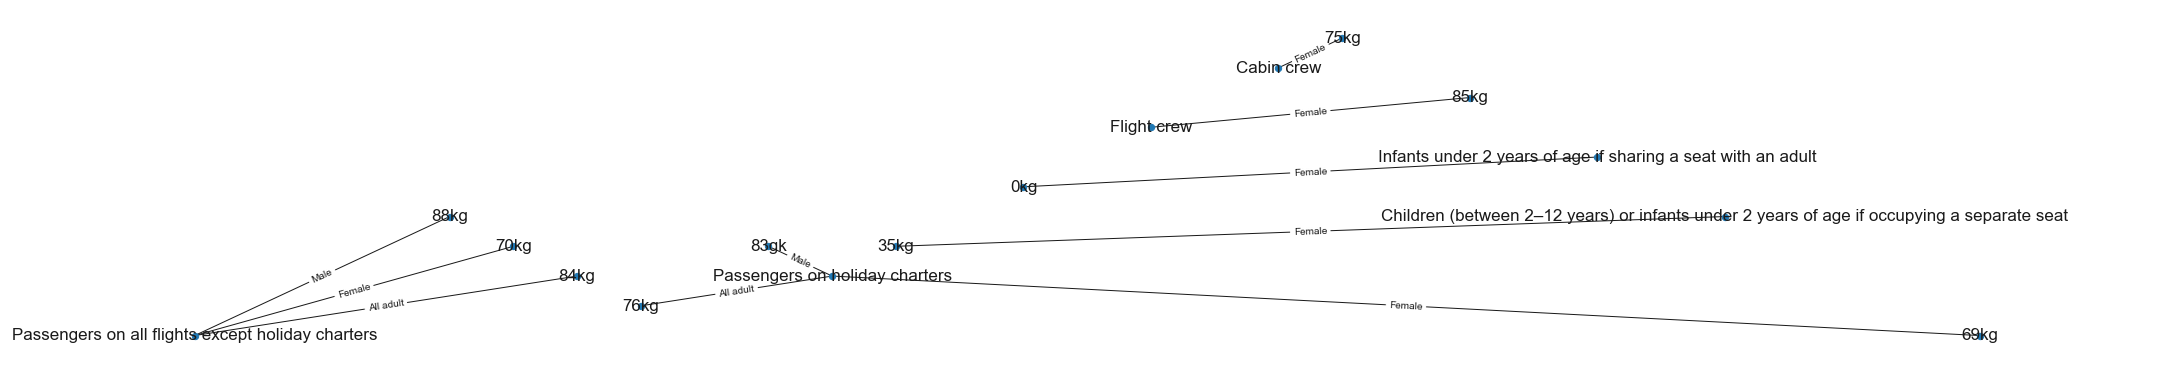

In [618]:
plt.figure(figsize=(30, 5))
pos = nx.planar_layout(
    G,scale=20
)  # For better example looking
nx.draw(G, pos, with_labels=True,node_size=40,font_size=17)
labels = {e: G.edges[e]['edge'] for e in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels,font_size=10)
plt.show()

In [47]:
table_triplets = pd.DataFrame(itertools.chain(*[table_triplets_extract(tab) for tab in table_extracted]),
             columns=['subject','relation','object'])
table_triplets = table_triplets.apply(lambda x:x.str.lower())
table_triplets

,subject,relation,object
0,passengers on all flights except holiday charters,male,88kg
1,passengers on holiday charters,male,83gk
2,children (between 2–12 years) or infants under...,male,35kg
3,infants under 2 years of age if sharing a seat...,male,0kg
4,flight crew,male,85kg
5,cabin crew,male,75kg
6,passengers on all flights except holiday charters,female,70kg
7,passengers on holiday charters,female,69kg
8,children (between 2–12 years) or infants under...,female,35kg
9,infants under 2 years of age if sharing a seat...,female,0kg


## Exporting the Knowledge graph - Module 3

In [48]:
## HTML creation of the graph tool for custom rule SVO graphs
# https://pyvis.readthedocs.io/en/latest/tutorial.html#visualization

nt = Network('720px','1280px',select_menu=True,
            directed=True,
            filter_menu=True,
#             neighborhood_highlight=True
                )
nt.add_nodes(df_graphs_custom['subject'].values)
nt.add_nodes(df_graphs_custom['object'].values)

for i in df_graphs_custom[['subject','object','edge']].values:
    nt.add_edge(i[0],i[1],title=i[2])

In [49]:
## To add the table triplets in the KG

nt.add_nodes(table_triplets['subject'].values)
nt.add_nodes(table_triplets['object'].values)

for i in table_triplets[['subject','object','relation']].values:
    nt.add_edge(i[0],i[1],title=i[2])
    

In [50]:
# os.chdir('results/')

In [51]:
## Save the tool in the result folder

nt.save_graph('KG_section1_customv2.html')

In [52]:
## HTML creation of the graph tool for Stanford OpenIE SVO graphs
# https://pyvis.readthedocs.io/en/latest/tutorial.html#visualization

nt = Network('720px','1280px',select_menu=True,
            directed=True,
            filter_menu=True,
#             neighborhood_highlight=True
                )
nt.add_nodes(df_graphs_openIE['subject'].values)
nt.add_nodes(df_graphs_openIE['object'].values)

for i in df_graphs_openIE[['subject','object','edge']].values:
    nt.add_edge(i[0],i[1],title=i[2])

In [53]:
## To add the table triplets in the KG

nt.add_nodes(table_triplets['subject'].values)
nt.add_nodes(table_triplets['object'].values)

for i in table_triplets[['subject','object','relation']].values:
    nt.add_edge(i[0],i[1],title=i[2])
    

In [54]:
## Save the tool in the result folder

nt.save_graph('KG_section1_openIEv2.html')

## Node embeddings exploration

In [55]:
G = nx.from_pandas_edgelist(df_graphs_openIE[['subject','edge','object']],
                           source='subject',
                           target='object')

In [56]:
#https://github.com/aditya-grover/node2vec
# Creatinf node embeddings using Node2vec

node2vec = n2v(
  G,
  dimensions=128
)

node2vec_model = node2vec.fit(
    vector_size = 32,
    window=2,
    min_count=2,
    batch_words=4
)

Computing transition probabilities:   0%|          | 0/251 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████| 10/10 [00:00<00:00, 18.21it/s]


In [393]:
node2vec_model.wv.most_similar('aircraft', topn = 10)

[('accordance with requirements', 0.9198664426803589),
 ('tow ropes', 0.9170794486999512),
 ('land order', 0.9161617755889893),
 ('banner', 0.9143261909484863),
 ('during day event failure anti-collision light provided',
  0.9133743643760681),
 ('event failure anti-collision light provided', 0.9104235768318176),
 ('similar articles', 0.9089250564575195),
 ('article', 0.9072456955909729),
 ('fly', 0.9018827080726624),
 ('paragraphs appropriate', 0.8369959592819214)]

In [57]:
embeddings_node2vec = pd.DataFrame(
        [node2vec_model.wv.get_vector(str(n)) for n in G.nodes()],
        index = G.nodes
    )

In [58]:
# PCA to project the vectors is 2D space
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

pca = PCA(n_components=2,random_state=9)

In [59]:
pca_node2vec = pca.fit_transform(embeddings_node2vec)

In [60]:
G = nx.from_pandas_edgelist(df_graphs_custom[['subject','edge','object']],
                           source='subject',
                           target='object')

node2vec = n2v(
  G,
  dimensions=128
)

node2vec_model = node2vec.fit(
    vector_size = 32,
    window=2,
    min_count=2,
    batch_words=4
)

embeddings_node2vec = pd.DataFrame(
        [node2vec_model.wv.get_vector(str(n)) for n in G.nodes()],
        index = G.nodes
    )

pca = PCA(n_components=2,random_state=9)

pca_node2vec_custom = pca.fit_transform(embeddings_node2vec)

Computing transition probabilities:   0%|          | 0/287 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████| 10/10 [00:00<00:00, 14.32it/s]


In [ ]:
# PCA scatterplot on nodes for custom rule KG

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='PCA-1', ylabel='PCA-2'>

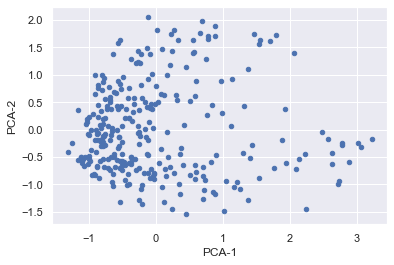

In [396]:
pd.DataFrame(pca_node2vec_custom,columns=['PCA-1','PCA-2']).plot.scatter(x='PCA-1',y='PCA-2')

In [ ]:
# PCA scatterplot on nodes for stanford openIE KG

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='PCA-1', ylabel='PCA-2'>

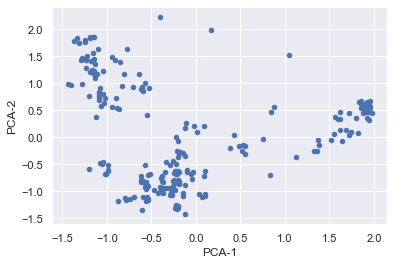

In [387]:
pd.DataFrame(pca_node2vec,columns=['PCA-1','PCA-2']).plot.scatter(x='PCA-1',y='PCA-2')

In [61]:
### END OF CODE ####